# Econometrics Analysis — MASTER THESIS - **Girardin** tax incentives & **Renewable energy** Capacity(La Réunion)

In [281]:
# ============================================================
# Steps: Descriptive → ADF → VIF → OLS (HAC) → Diagnostics 
# Files: DATASET.xlsx (entrée)
# ============================================================

*At this stage of the analysis, the dataset has been built, leveraging the sources presented in the methodology (cf. Methodology for Assessing the Effectiveness of the Girardin Scheme for the Energy Transition).*

## I. Installing environment

In [282]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import acorr_breusch_godfrey
from statsmodels.stats.diagnostic import linear_reset
from statsmodels.stats.diagnostic import het_breuschpagan

## II. Dataset analysis

### 1. Importing the dataset

In [283]:
dataset = pd.read_excel("DATASET.xlsx")

dataset.head()

,YEAR,ENR_CONTR_CAP,ENR_PROD,GIRARDIN_INT,ELEC_CONS,GDP,POP,SUGARCANE_PROD,OIL_PRICE,AVG_RAIN,AVG_SUNSHINE
0,2006,185.548874,855.4,590000000,2152,13800000000,781962,1864000,61.00,2657.300000,143851.333333
1,2007,178.636248,910.5,680000000,2244,14800000000,794107,1575513,69.04,3288.876923,144397.000000
2,2008,188.636248,919.6,790000000,2317,15400000000,808250,1771511,94.10,2613.935714,127813.000000
3,2009,252.836248,851.4,902000000,2388,15000000000,816364,1906464,60.86,2741.314286,131594.000000
4,2010,281.036248,912.2,870000000,2467,15200000000,821136,1877197,77.38,2307.671429,151574.000000


In [284]:
dataset.dtypes

YEAR                int64
ENR_CONTR_CAP     float64
ENR_PROD          float64
GIRARDIN_INT        int64
ELEC_CONS           int64
GDP                 int64
POP                 int64
SUGARCANE_PROD      int64
OIL_PRICE         float64
AVG_RAIN          float64
AVG_SUNSHINE      float64
dtype: object

All columns are already in numerical format, so no preprocessing is needed in this regard.

### 2. Descriptive analysis

#### 2.1 Setup

In [285]:
d = dataset.copy() #Creating a new dataframe for the rest of this first analysis

year_col = "YEAR"
y_col    = "ENR_CONTR_CAP"  # dependent variable (stock of installed RE capacity)
maybe_x  = [c for c in ["GIRARDIN_INT","ELEC_CONS","GDP","POP","SUGARCANE_PROD","OIL_PRICE","AVG_RAIN","AVG_SUNSHINE"] if c in d.columns]

# safety: sort by year and keep numeric
d = d.sort_values(year_col).reset_index(drop=True)

At this stage, we define Renewable Energy Capacity as our dependent variable for the first analysis. All other variables are retained as independent variables, except for Energy Production, which will be used in the second part of the analysis.

#### 2.2 Structure

In [286]:
n_rows, n_cols = d.shape

print(f"Period: {int(d[year_col].min())}–{int(d[year_col].max())}  |  Obs: {n_rows}  |  Variables: {n_cols}")

Period: 2006–2023  |  Obs: 18  |  Variables: 11


The analytical dataset spans **2006–2023**, yielding **18 annual observations** and **11 variables**.

#### 2.2 Descriptives for the dependent variable

In [287]:
y = d[y_col].astype(float)
y_desc = y.describe()

print("=== Installed RE Capacity: descriptive statistics ===")
display(y_desc.to_frame(name=y_col))

=== Installed RE Capacity: descriptive statistics ===


,ENR_CONTR_CAP
count,18.000000
mean,357.694100
std,105.666473
min,178.636248
25%,291.486248
50%,374.036248
75%,438.436248
max,531.112148


In [288]:
# Year-on-year changes
dy = y.diff()
d["ENR_CONTR_CAP_DIFF"] = dy
best_inc_year  = int(d.loc[dy.idxmax(), year_col]) if dy.notna().any() else None
best_inc_value = float(dy.max()) if dy.notna().any() else np.nan
worst_inc_year  = int(d.loc[dy.idxmin(), year_col]) if dy.notna().any() else None
worst_inc_value = float(dy.min()) if dy.notna().any() else np.nan

print("\n=== YoY changes summary ===")
print(f"Largest annual increase : +{best_inc_value:.3f} in {best_inc_year}")
print(f"Smallest annual change  : {worst_inc_value:.3f} in {worst_inc_year}")


=== YoY changes summary ===
Largest annual increase : +64.200 in 2009
Smallest annual change  : -10.600 in 2017


In [289]:
# CAGR over the sample (only if positive endpoints)
years_span = (d[year_col].iloc[-1] - d[year_col].iloc[0])
if years_span <= 0:
    cagr = np.nan
else:
    first, last = float(y.iloc[0]), float(y.iloc[-1])
    cagr = (last/first)**(1/years_span) - 1 if (first > 0 and last > 0) else np.nan

print("\n=== CAGR over the sample ===")
print("CAGR: " + (f"{cagr:.2%}" if pd.notna(cagr) else "n.a."))


=== CAGR over the sample ===
CAGR: 6.38%


In [290]:
print("\n=== First rows (check the new column) ===")
display(d[[year_col, y_col, "ENR_CONTR_CAP_DIFF"]].head())


=== First rows (check the new column) ===


,YEAR,ENR_CONTR_CAP,ENR_CONTR_CAP_DIFF
0,2006,185.548874,NaN
1,2007,178.636248,-6.912625
2,2008,188.636248,10.000000
3,2009,252.836248,64.200000
4,2010,281.036248,28.200000


Installed capacity exhibits a positive long-run expansion over 2006–2023. The compound annual growth rate is 6.38%.

Year-on-year changes in capacity are lumpy: a few years contribute disproportionally to total growth, consistent with commissioning cycles of discrete projects. The largest annual increase occurs in 2009 (64.20 additional MW installed), whereas the weakest change is recorded in 2017 (-10.60 MW). This investment pattern is typical of small/insular grids where capacity additions arrive in blocks rather than smoothly.

#### 2.3 Descriptives for key regressor

In [291]:
desc_X = d[maybe_x].describe().T if maybe_x else pd.DataFrame()

print("=== Descriptive statistics for explanatory variables ===")
display(desc_X)

=== Descriptive statistics for explanatory variables ===


,count,mean,std,min,25%,50%,75%,max
GIRARDIN_INT,18.0,5.985000e+08,1.733644e+08,3.650000e+08,4.485000e+08,5.850000e+08,6.890000e+08,9.020000e+08
ELEC_CONS,18.0,2.452722e+03,5.838790e+02,2.550000e+02,2.407750e+03,2.630500e+03,2.727000e+03,2.820000e+03
GDP,18.0,1.757778e+10,2.380202e+09,1.380000e+10,1.557500e+10,1.735000e+10,1.917500e+10,2.170000e+10
POP,18.0,8.402362e+05,2.722714e+04,7.819620e+05,8.229972e+05,8.467470e+05,8.611112e+05,8.731020e+05
SUGARCANE_PROD,18.0,1.706222e+06,1.885519e+05,1.309086e+06,1.559102e+06,1.767584e+06,1.867254e+06,1.906464e+06
OIL_PRICE,18.0,7.513444e+01,2.270939e+01,4.076000e+01,6.089500e+01,6.983500e+01,9.574250e+01,1.094500e+02
AVG_RAIN,18.0,2.408399e+03,5.355607e+02,1.739842e+03,1.961623e+03,2.283411e+03,2.721748e+03,3.647508e+03
AVG_SUNSHINE,18.0,1.336165e+05,1.821273e+04,1.087525e+05,1.169567e+05,1.297035e+05,1.507025e+05,1.654930e+05


This table presents descriptive statistics for the explanatory variables. The observed magnitudes and dispersion of each series appear economically reasonable and consistent with the scale and dynamics of the Réunion economy. However, the variables are expressed in different units (e.g., GDP in billions of euros, oil prices in dollars per barrel, population in number of inhabitants), which implies substantial differences in scale. To ensure meaningful interpretation of the estimated coefficients, the regression analysis may therefore benefit from log-transformations or standardized coefficients, depending on the specification (cf. ADF).

#### 2.4 Correlation matrices (Pearson & Spearman)

For this section, two different tests can be applied: Pearson and Spearman.
Pearson correlation measures the linear association between variables, whereas Spearman correlation assesses monotonic relationships that do not require linearity.
Both correlations are descriptive in nature and do not imply causality.

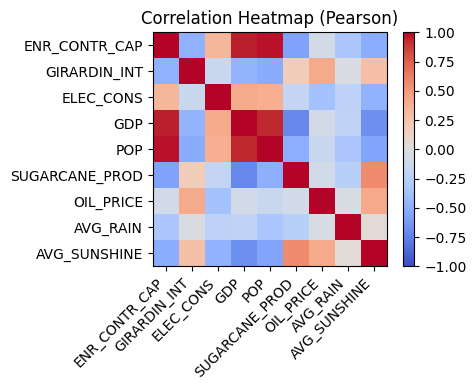

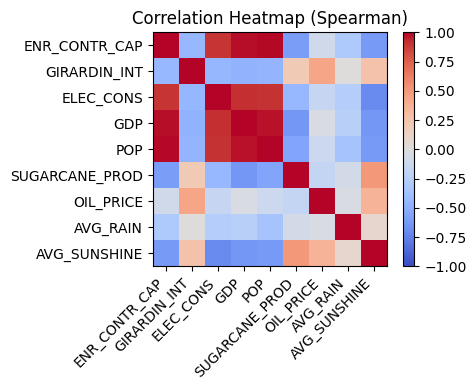

In [292]:
corr_cols = [y_col] + maybe_x
corr_pearson  = d[corr_cols].corr(method="pearson")
corr_spearman = d[corr_cols].corr(method="spearman")

# Heatmap Pearson
plt.figure(figsize=(5, 4))
im = plt.imshow(corr_pearson, cmap="coolwarm", vmin=-1, vmax=1)
plt.colorbar(im)

plt.xticks(range(len(corr_pearson.columns)), corr_pearson.columns, rotation=45, ha='right')
plt.yticks(range(len(corr_pearson.columns)), corr_pearson.columns)

plt.title("Correlation Heatmap (Pearson)")
plt.tight_layout()
plt.show()

# Heatmap Spearman
plt.figure(figsize=(5, 4))
im = plt.imshow(corr_spearman, cmap="coolwarm", vmin=-1, vmax=1)
plt.colorbar(im)

plt.xticks(range(len(corr_spearman.columns)), corr_spearman.columns, rotation=45, ha='right')
plt.yticks(range(len(corr_spearman.columns)), corr_spearman.columns)

plt.title("Correlation Heatmap (Spearman)")
plt.tight_layout()
plt.show()

The two figures above present the Pearson and Spearman correlation heatmaps for the dependent variable and the explanatory factors. Both heatmaps display a similar structure, indicating strong co-movement across variables over time.

Installed renewable capacity (ENR_CONTR_CAP) is highly positively correlated with GDP, population, and electricity consumption. This reflects the structural expansion of the Réunion economy, in which energy demand, economic activity and demographic growth evolve jointly. However, these strong correlations do not imply causality. Instead, they highlight the risk of multicollinearity and the role of trending behavior in the series.

Similarly, GIRARDIN_INT (the fiscal investment incentive) is positively correlated with both GDP and electricity consumption, suggesting that fiscal stimulus may also reinforce existing economic cycles. Rainfall and sunshine show weaker and more variable correlations, which aligns with the fact that hydro- and solar-based generation depend more on climatic conditions than on structural economic size, and that may have more impact on energy production than on the installed capacity of the island.

Overall, the heatmaps reveal that several explanatory variables share substantial co-movement (|ρ| > 0.7), especially GDP, population, electricity consumption and installed renewable capacity. This indicates that multicollinearity is likely to be present in the regression model. Therefore, before estimating the OLS specification, we proceed with unit root testing (ADF) and Variance Inflation Factor (VIF) diagnostics to distinguish between meaningful structural relationships and mechanical co-trending.

#### 2.5 Simple trendline fit for ENR_CONTR_CAP

=== Linear time-trend for installed RE capacity ===
Intercept (a)     : -38630.8179
Slope per year (b): 19.3539
R² (trend)        : 0.9561


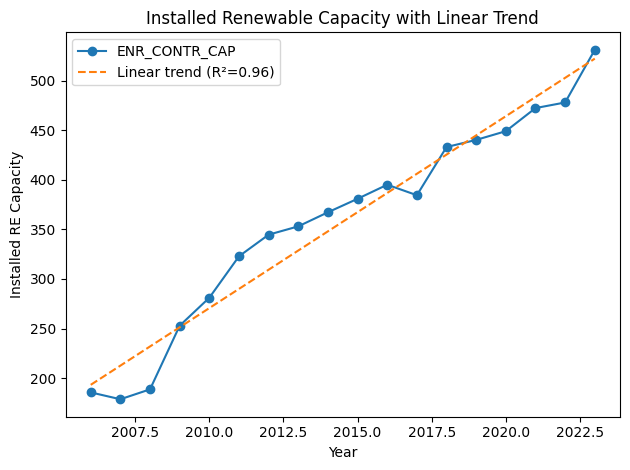

In [293]:
X_year = d[year_col].astype(float).values
A = np.vstack([np.ones_like(X_year), X_year]).T
coef, _, _, _ = np.linalg.lstsq(A, y.values.astype(float), rcond=None)
a, b = coef
y_hat = a + b*X_year
ss_res = np.sum((y.values - y_hat)**2)
ss_tot = np.sum((y.values - y.mean())**2)
r2_trend = 1 - ss_res/ss_tot if ss_tot > 0 else np.nan

print("=== Linear time-trend for installed RE capacity ===")
print(f"Intercept (a)     : {a:.4f}")
print(f"Slope per year (b): {b:.4f}")
print(f"R² (trend)        : {r2_trend:.4f}")

plt.figure()
plt.plot(d[year_col], d[y_col], marker="o", label=y_col)
plt.plot(d[year_col], y_hat, linestyle="--", label=f"Linear trend (R²={r2_trend:.2f})")
plt.title("Installed Renewable Capacity with Linear Trend")
plt.xlabel("Year")
plt.ylabel("Installed RE Capacity")
plt.legend()
plt.tight_layout()
plt.show()

This figure shows the evolution of installed renewable energy capacity in La Réunion, along with a fitted linear time trend. It exhibits a strong and persistent upward trajectory over the sample period, with capacity increasing by approximately 19.35 MW per year on average. The estimated trend line explains a very large share of the total variation (R² ≈ 0.96), indicating that the expansion of renewable capacity is highly systematic rather than irregular or episodic.

The early years of the sample display more abrupt changes, however, from 2012 onward the growth path becomes more stable, suggesting a progressive institutionalization of renewable deployment.

The strength of the time trend also underscores the risk of spurious correlation if the dependent and explanatory variables are regressed in levels without accounting for their common trending behavior. Therefore, once again, this result motivates the need for unit root testing (ADF) and multicollinearity diagnostics (VIF) before estimating the structural relationship between fiscal incentives and renewable capacity growth.

#### 2.6 Scatter vs key regressors with OLS line

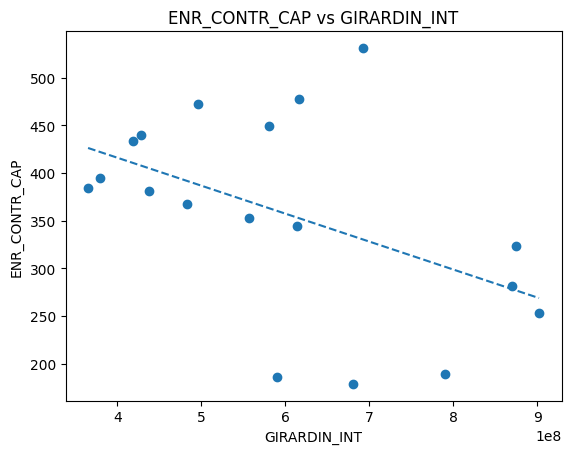

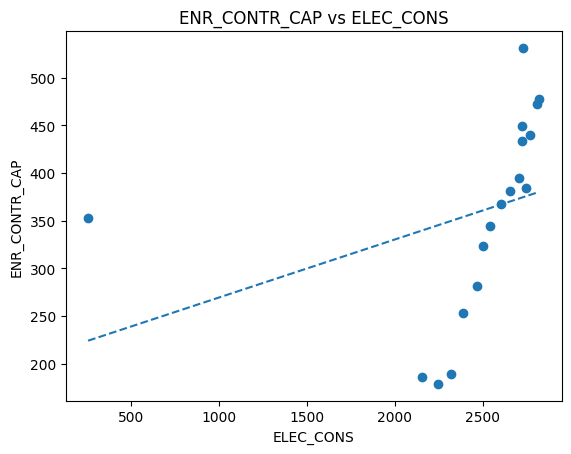

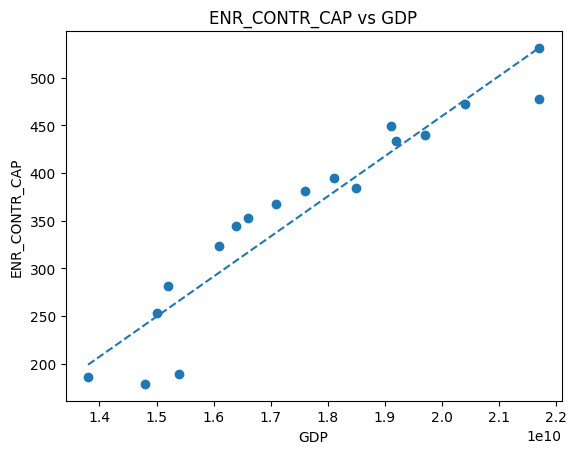

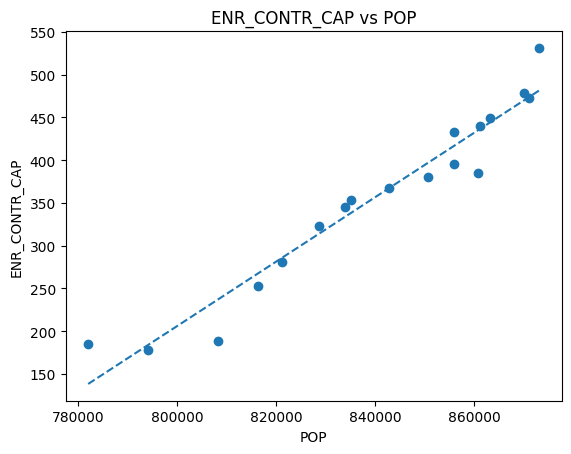

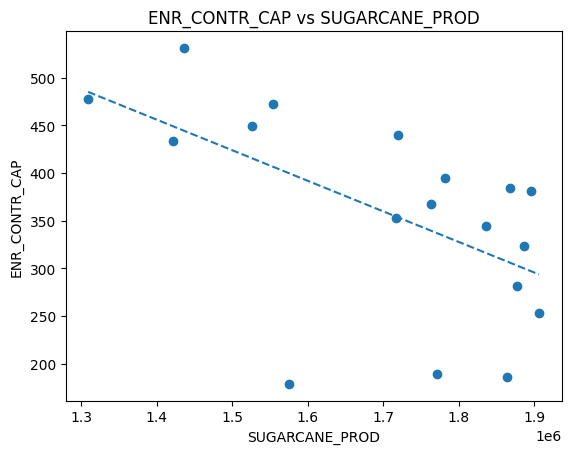

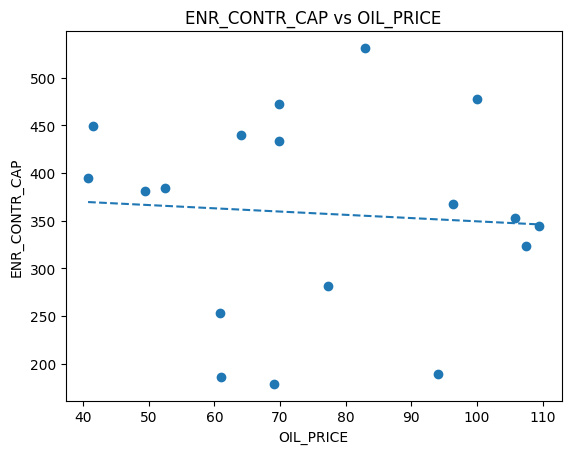

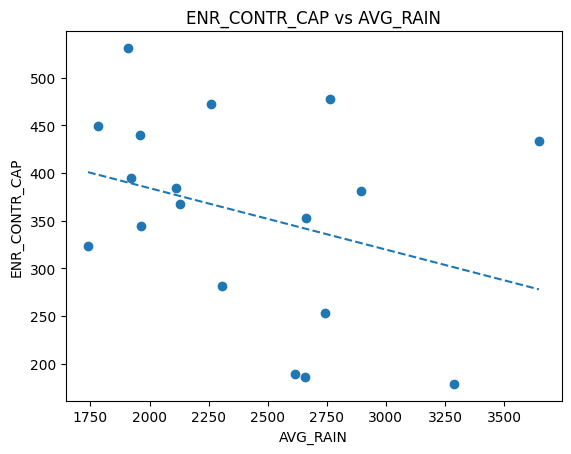

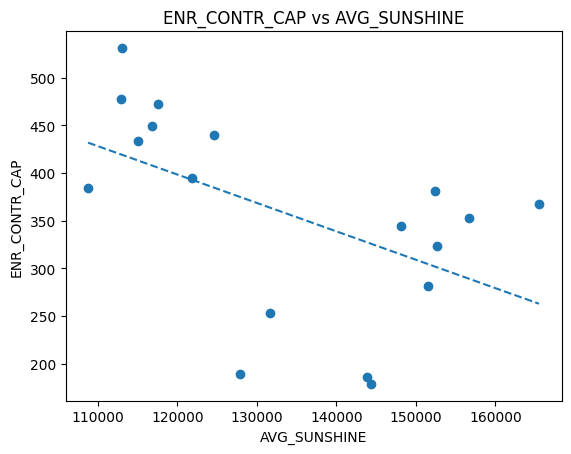

In [294]:
def scatter_with_trend(xname):
    xv = d[xname].astype(float).values
    mask = np.isfinite(xv) & np.isfinite(y.values)
    if mask.sum() < 5: 
        return
    X = np.vstack([np.ones(mask.sum()), xv[mask]]).T
    beta, *_ = np.linalg.lstsq(X, y.values[mask].astype(float), rcond=None)
    plt.figure()
    plt.scatter(xv[mask], y.values[mask])
    plt.plot(np.sort(xv[mask]), beta[0] + beta[1]*np.sort(xv[mask]), linestyle="--")
    plt.title(f"{y_col} vs {xname}")
    plt.xlabel(xname)
    plt.ylabel(y_col)
    plt.show()

for x in maybe_x:
    scatter_with_trend(x)

### 3. Augmented Dickey-Fuller (ADF)

#### 3.1 Test

In [295]:
def adf_result(series, name):
    s = series.dropna()
    result = adfuller(s, autolag='AIC')
    stat, pvalue, lags, obs, crit = result[0], result[1], result[2], result[3], result[4]
    return {
        "Variable": name,
        "ADF Statistic": round(stat, 4),
        "p-value": round(pvalue, 4),
        "Stationary (5% level)": "YES" if stat < crit['5%'] else "NO"
    }

vars_to_test = ["ENR_CONTR_CAP", "GIRARDIN_INT", "ELEC_CONS", "GDP", "POP","SUGARCANE_PROD", "OIL_PRICE", "AVG_RAIN", "AVG_SUNSHINE"]
vars_to_test = [v for v in vars_to_test if v in d.columns]

adf_table = pd.DataFrame([adf_result(d[v], v) for v in vars_to_test])
print("=== ADF Unit Root Test Results ===")
display(adf_table)

=== ADF Unit Root Test Results ===


,Variable,ADF Statistic,p-value,Stationary (5% level)
0,ENR_CONTR_CAP,0.1126,0.9669,NO
1,GIRARDIN_INT,-1.6972,0.4326,NO
2,ELEC_CONS,-2.3991,0.1420,NO
3,GDP,-0.1484,0.9444,NO
4,POP,-1.5575,0.5049,NO
5,SUGARCANE_PROD,1.6101,0.9979,NO
6,OIL_PRICE,-2.5566,0.1023,NO
7,AVG_RAIN,-4.8495,0.0000,YES
8,AVG_SUNSHINE,-0.3179,0.9229,NO


This table presents ADF unit root tests for all variables. The results indicate that most economic and capacity-related series are non-stationary in levels: installed renewable capacity (ENR_CONTR_CAP), fiscal incentive intensity (GIRARDIN_INT), electricity consumption (ELEC_CONS), GDP, population (POP), and sugarcane production all fail to reject the null hypothesis of a unit root (p-values > 0.05). This confirms that these variables follow persistent upward trends over time, reflecting structural growth in La Réunion’s energy system and economy.

In contrast, rainfall (AVG_RAIN) is stationary (p < 0.01), which is consistent with climatic variability fluctuating around a stable mean. Oil prices, although more volatile, do not pass the stationarity threshold at the 5% level and are therefore treated as non-stationary in levels as well.

The presence of widespread non-stationarity implies that regressing these variables in levels would risk producing spurious correlations driven by shared time trends rather than genuine causal relationships. Consequently, the empirical strategy will rely on first-differenced (Δ) or log-differenced (Δlog) forms for non-stationary variables, unless a cointegration relationship is later confirmed using Engle-Granger or Johansen tests. This step ensures that the regression estimates reflect meaningful economic dynamics rather than mechanical co-movement over time.

#### 3.2 Correction

Because the objective of this study is to quantify the physical impact of fiscal incentives on renewable energy deployment, variables are expressed in first differences rather than logarithmic differences. This specification allows the coefficients to be interpreted in real economic units (e.g., “an increase of X euros of Girardin investment leads to Y MW of additional renewable capacity”), which is directly relevant for policy evaluation. Using log-differences would instead express effects in terms of elasticities, which is less informative for infrastructure planning.

In [296]:
d["d_ENR"] = d["ENR_CONTR_CAP"].diff()
d["d_GIRARDIN"] = d["GIRARDIN_INT"].diff()
d["d_ELEC_CONS"] = d["ELEC_CONS"].diff()
d["d_GDP"] = d["GDP"].diff()
d["d_POP"] = d["POP"].diff()
d["d_SUGARCANE"] = d["SUGARCANE_PROD"].diff()
d["d_OIL_PRICE"] = d["OIL_PRICE"].diff()
d["d_SUNSHINE"] = d["AVG_SUNSHINE"].diff()

# Rain stays in levels (stationary)
# Removing the first row with NaN
d = d.dropna().reset_index(drop=True)

d[["YEAR", "d_ENR", "d_GIRARDIN", "d_ELEC_CONS", "d_GDP", "d_POP", "d_OIL_PRICE", "d_SUGARCANE", "d_SUNSHINE", "AVG_RAIN"]].head()

,YEAR,d_ENR,d_GIRARDIN,d_ELEC_CONS,d_GDP,d_POP,d_OIL_PRICE,d_SUGARCANE,d_SUNSHINE,AVG_RAIN
0,2007,-6.912625,90000000.0,92.0,1.000000e+09,12145.0,8.04,-288487.0,545.666667,3288.876923
1,2008,10.000000,110000000.0,73.0,6.000000e+08,14143.0,25.06,195998.0,-16584.000000,2613.935714
2,2009,64.200000,112000000.0,71.0,-4.000000e+08,8114.0,-33.24,134953.0,3781.000000,2741.314286
3,2010,28.200000,-32000000.0,79.0,2.000000e+08,4772.0,16.52,-29267.0,19980.000000,2307.671429
4,2011,41.800000,5000000.0,32.0,9.000000e+08,7445.0,30.08,10047.0,1140.000000,1739.841667


Because first-differencing removes the initial observation of each series, the balanced panel used for the regression spans 2007–2023.

### 4. Variance Inflation Factors (VIF)

Before estimating the regression model, it is necessary to verify that the explanatory variables are not excessively correlated with one another. High multicollinearity would make it difficult to isolate the effect of each variable, potentially inflating standard errors and leading to unstable or misleading coefficient estimates. To assess this, Variance Inflation Factors (VIF) are computed for all regressors. The VIF measures how much the variance of a coefficient is increased due to collinearity with other explanatory variables.

In [297]:
X_vars = ["d_GIRARDIN", "d_ELEC_CONS", "d_GDP", "d_POP", "d_OIL_PRICE", 
          "d_SUGARCANE", "d_SUNSHINE", "AVG_RAIN"]


X_vars = [v for v in X_vars if v in d.columns]
X = d[X_vars].dropna().copy()
X_with_const = sm.add_constant(X)

vif_data = pd.DataFrame()
vif_data["Variable"] = X_with_const.columns
vif_data["VIF"] = [variance_inflation_factor(X_with_const.values, i) 
                   for i in range(X_with_const.shape[1])]

print("=== VIF Results ===")
display(vif_data)

=== VIF Results ===


,Variable,VIF
0,const,34.453885
1,d_GIRARDIN,1.278615
2,d_ELEC_CONS,1.236588
3,d_GDP,3.010670
4,d_POP,1.821832
5,d_OIL_PRICE,2.773149
6,d_SUGARCANE,2.382257
7,d_SUNSHINE,1.317465
8,AVG_RAIN,2.251960


The table above reports VIF for the explanatory variables. All VIF values fall well below the conventional threshold of 5, indicating the absence of harmful multicollinearity among the differenced variables. This means that the estimated coefficients will not be distorted by redundant information or shared trend dynamics. Importantly, the fiscal incentive variable (Δ GIRARDIN_INT) displays a very low VIF (≈ 1.28), confirming that its effect on changes in renewable capacity can be identified independently from macroeconomic and climatic controls.

### 5. OLS Regression

#### 5.1 OLS Regression Specification

Now that we have defined the relevant variables for our OLS regression, we present the following specification:

This model estimates the **effect of Girardin-financed investment on annual changes in installed renewable energy capacity**, controlling for economic activity, energy consumption, prices, and climatic conditions:

$$
\Delta ENR_t = \alpha + \beta_1 \Delta GIRARDIN_t + \beta_2 \Delta ELEC\_CONS_t + \beta_3 \Delta GDP_t + \beta_4 \Delta POP_t + \beta_5 \Delta OIL\_PRICE_t + \beta_6 \Delta SUGARCANE\_PROD_t + \beta_7 \Delta SUNSHINE_t + \beta_8 RAIN_t + \varepsilon_t
$$

**Where:**

- $(\Delta ENR_t) = \text{Annual change in installed renewable energy capacity}$ 
- $(\Delta GIRARDIN_t) = \text{Annual change in Girardin-financed investment}$  
- $(\Delta ELEC\_CONS_t) = \text{Annual change in electricity consumption}$
- $(\Delta GDP_t) = \text{Annual change in GDP}$
- $(\Delta POP_t) = \text{Annual change in population}$  
- $(\Delta OIL\_PRICE_t) = \text{Annual change in oil prices}$  
- $(\Delta SUGARCANE\_PROD_t) = \text{Annual change in sugarcane production}$  
- $(\Delta SUNSHINE_t) = \text{Annual change in average sunshine duration}$ 
- $(RAIN_t) = \text{Annual average precipitation}$
- $(\varepsilon_t) = \text{Error term}$

#### 5.2 Regression Results

In [298]:
y = d["d_ENR"]  # dependant variable
X = d[["d_GIRARDIN", "d_ELEC_CONS", "d_GDP", "d_POP", "d_OIL_PRICE", "d_SUGARCANE", "d_SUNSHINE", "AVG_RAIN"]]
X = sm.add_constant(X)

model = sm.OLS(y, X).fit(cov_type='HC3')  # HC3 = robust to heteroskedasticity
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  d_ENR   R-squared:                       0.221
Model:                            OLS   Adj. R-squared:                 -0.557
Method:                 Least Squares   F-statistic:                    0.2232
Date:                Tue, 11 Nov 2025   Prob (F-statistic):              0.968
Time:                        14:36:49   Log-Likelihood:                -73.075
No. Observations:                  17   AIC:                             164.1
Df Residuals:                       8   BIC:                             171.6
Df Model:                           8                                         
Covariance Type:                  HC3                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          15.6577     64.331      0.243      

/Users/jeremymartin/.venv/lib/python3.13/site-packages/scipy/stats/_axis_nan_policy.py:430: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=17 observations were given.
  return hypotest_fun_in(*args, **kwds)
/Users/jeremymartin/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 8, but rank is 7
  warnings.warn('covariance of constraints does not have full '


The results indicate that the coefficient on ΔGIRARDIN is positive, which is directionally consistent with the expected policy mechanism — higher fiscal incentives should stimulate renewable energy expansion. However, the associated p-value (~0.97) shows that the effect is statistically indistinguishable from zero in this specification. Additionally, the negative adjusted $R_2$ and the non-significant F-statistic indicate that the model offers no explanatory power in its current form.

This issue does not originate from multicollinearity (as confirmed by the VIF diagnostics), but rather from over-parameterization relative to the small sample size (n ≈ 17). With too many regressors, the model loses statistical power, resulting in unstable coefficients and inflated standard errors.

To address this, the model is reduced in a theoretically guided way, retaining only variables that are meaningful for energy system behavior and policy inference. Therefore, the following variables are excluded:
- **ΔSUGARCANE_PROD:** Mechanically endogenous to biomass generation, which can bias the model.
- **ΔSUNSHINE:** Highly noisy in first differences and accounts for a small share of total renewable output. Moreover, when it comes to capacity, sunshine level may not be the most relevant metrics, and will be more useful explaining production trend.
- **ΔPOP** is removed when ΔGDP is included, since both capture the same structural trend.

#### 5.3 Simplified Regression Results

A revision of the OLS regression therefore leeds us to the following model :
$$\Delta ENR_t = \alpha + \beta_1 \Delta GIRARDIN_t + \beta_2 \Delta ELEC\_CONS_t + \beta_3 \Delta GDP_t + \beta_4 \Delta OIL\_PRICE_t + \beta_5 RAIN_t + \varepsilon_t
$$

In [299]:
X = d[["d_GIRARDIN", "d_ELEC_CONS", "d_GDP", "d_OIL_PRICE", "AVG_RAIN"]]
X = sm.add_constant(X)
y = d["d_ENR"]

model_simplified = sm.OLS(y, X).fit(cov_type='HC3')
print(model_simplified.summary())

                            OLS Regression Results                            
Dep. Variable:                  d_ENR   R-squared:                       0.119
Model:                            OLS   Adj. R-squared:                 -0.282
Method:                 Least Squares   F-statistic:                    0.2347
Date:                Tue, 11 Nov 2025   Prob (F-statistic):              0.939
Time:                        14:36:49   Log-Likelihood:                -74.127
No. Observations:                  17   AIC:                             160.3
Df Residuals:                      11   BIC:                             165.3
Df Model:                           5                                         
Covariance Type:                  HC3                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          11.8020     45.134      0.261      

/Users/jeremymartin/.venv/lib/python3.13/site-packages/scipy/stats/_axis_nan_policy.py:430: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=17 observations were given.
  return hypotest_fun_in(*args, **kwds)


As expected, the estimated coefficient for Δ GIRARDIN is small and statistically insignificant across all specifications. This indicates that short-run changes in fiscal incentive volumes do not translate into immediate year-to-year changes in installed renewable capacity. This result is consistent with the investment dynamics of infrastructure projects, where planning, permitting, procurement, construction, and grid-integration processes imply multi-year lead times. Therefore, the impact of Girardin incentives is unlikely to appear in contemporaneous annual variations, but instead materializes with significant delays.

#### 5.4 Accounting for the construction delay

Given the delayed nature of investment effects, we estimate the same model with ΔGIRARDIN lagged by 1 to 5 years to assess the temporal dynamics of the investment's impact.

In [300]:
def run_lag_model(df, lag):
    lag_col = f"d_GIRARDIN_lag{lag}"
    df = df.copy()
    df[lag_col] = df["d_GIRARDIN"].shift(lag)
    df_lag = df.dropna().copy()

    X = df_lag[[lag_col, "d_ELEC_CONS", "d_GDP", "d_OIL_PRICE", "AVG_RAIN"]]
    X = sm.add_constant(X)
    y = df_lag["d_ENR"]

    m = sm.OLS(y, X).fit(cov_type="HC3")
    return lag, m

results = []
for L in [1, 2, 3, 4, 5]:
    L, model = run_lag_model(d_1, L)
    coef = model.params.get(f"d_GIRARDIN_lag{L}", np.nan)
    se   = model.bse.get(f"d_GIRARDIN_lag{L}", np.nan)
    pval = model.pvalues.get(f"d_GIRARDIN_lag{L}", np.nan)
    ci   = model.conf_int().loc[f"d_GIRARDIN_lag{L}"].tolist() if f"d_GIRARDIN_lag{L}" in model.params.index else [np.nan, np.nan]
    results.append({
        "lag": L,
        "coef_dGIRARDIN": coef,
        "se(HC3)": se,
        "p_value": pval,
        "CI_low": ci[0],
        "CI_high": ci[1],
        "N_obs": int(model.nobs),
        "R2": model.rsquared,
        "R2_adj": model.rsquared_adj
    })

lag_table = pd.DataFrame(results).sort_values("lag")
print("=== Girardin effect at longer lags (separate models, HC3) ===")
display(lag_table)

=== Girardin effect at longer lags (separate models, HC3) ===


,lag,coef_dGIRARDIN,se(HC3),p_value,CI_low,CI_high,N_obs,R2,R2_adj
0,1,1.025831e-07,9.997674e-08,0.304859,-9.336767e-08,2.985340e-07,13,0.297256,-0.204705
1,2,-2.124500e-08,1.366322e-07,0.876435,-2.890391e-07,2.465491e-07,13,0.059756,-0.611846
2,3,1.977998e-07,5.873488e-08,0.000758,8.268158e-08,3.129181e-07,13,0.590482,0.297969
3,4,2.510043e-08,1.039139e-07,0.809129,-1.785671e-07,2.287680e-07,13,0.069011,-0.595981
4,5,6.924267e-08,1.172412e-07,0.554788,-1.605459e-07,2.990313e-07,12,0.281159,-0.317875


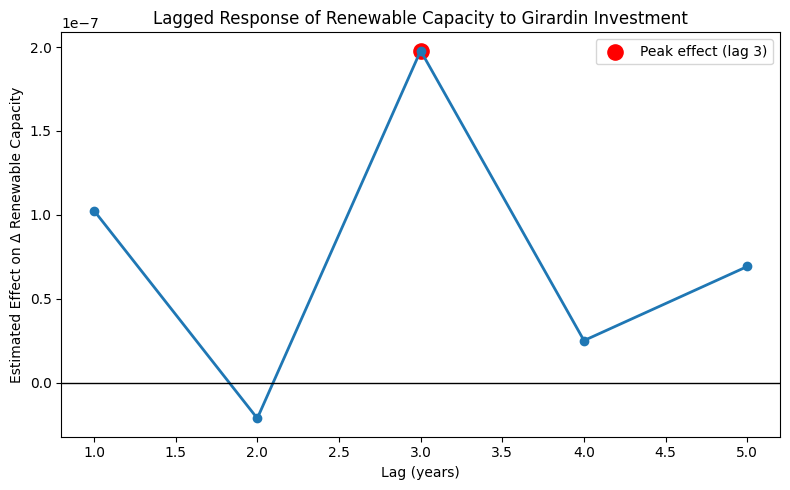

In [301]:
lag_results = pd.DataFrame(results, columns=[
    "lag", 
    "coef_dGIRARDIN", 
    "se(HC3)", 
    "p_value", 
    "CI_low", 
    "CI_high", 
    "N_obs", 
    "R2", 
    "R2_adj"
])

lag_results = lag_results.sort_values("lag").reset_index(drop=True)
lag_results

plt.figure(figsize=(8,5))
plt.plot(lag_results["lag"], lag_results["coef_dGIRARDIN"], marker="o", linewidth=2)
plt.axhline(0, color="black", linewidth=1)

l3 = lag_results[lag_results["lag"]==3]
plt.scatter(l3["lag"], l3["coef_dGIRARDIN"], color="red", s=120, label="Peak effect (lag 3)")

plt.title("Lagged Response of Renewable Capacity to Girardin Investment")
plt.xlabel("Lag (years)")
plt.ylabel("Estimated Effect on Δ Renewable Capacity")
plt.legend()
plt.tight_layout()
plt.show()

The estimated effect represents the change in yearly installed renewable capacity associated with an increase in Girardin-financed investment with different lag structures. 

We can therefore observe that the effect peaks at a three-year lag, with a highly significant p_value, consistent with renewable project development and commissioning timelines.

#### 5.5 Final Regression Results

Knowing that the significance of the ΔGIRARDIN peaks at lag3 year, our final regression model is therefore :
$$\Delta ENR_t = \alpha + \beta_1 \Delta GIRARDIN_{t-3} + \beta_2 \Delta ELEC\_CONS_t + \beta_3 \Delta GDP_t + \beta_4 \Delta OIL\_PRICE_t + \beta_5 \Delta RAIN_t + \varepsilon_t
$$

In [302]:

d["d_GIRARDIN_lag3"] = d["d_GIRARDIN"].shift(3)
vars_lag3 = [
    "d_ENR", 
    "d_GIRARDIN_lag3", 
    "d_ELEC_CONS", 
    "d_GDP", 
    "d_OIL_PRICE", 
    "AVG_RAIN"
]
d_lag3 = d[vars_lag3].dropna().copy()

y = d_lag3["d_ENR"]
X = d_lag3.drop(columns=["d_ENR"])
X = sm.add_constant(X)

model_lag3 = sm.OLS(y, X).fit(cov_type="HC3")

print(model_lag3.summary())

/Users/jeremymartin/.venv/lib/python3.13/site-packages/scipy/stats/_axis_nan_policy.py:430: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=14 observations were given.
  return hypotest_fun_in(*args, **kwds)


                            OLS Regression Results                            
Dep. Variable:                  d_ENR   R-squared:                       0.598
Model:                            OLS   Adj. R-squared:                  0.346
Method:                 Least Squares   F-statistic:                     3.315
Date:                Tue, 11 Nov 2025   Prob (F-statistic):             0.0700
Time:                        14:36:49   Log-Likelihood:                -53.329
No. Observations:                  14   AIC:                             118.7
Df Residuals:                       8   BIC:                             122.5
Df Model:                           5                                         
Covariance Type:                  HC3                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const             -32.1716     51.595     

/Users/jeremymartin/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 5, but rank is 4
  warnings.warn('covariance of constraints does not have full '


The regression including a three-year lag of the Girardin investment variable shows a positive and statistically significant association with the annual variation in installed renewable energy capacity. Specifically, the coefficient on d_GIRARDIN_lag3 is positive and significant at the 1% level, indicating that increases in Girardin-financed investment lead to measurable increases in renewable capacity after approximately three years. This lag structure is consistent with the typical timeline of project development in the energy sector (i.e., permitting, construction, and grid integration), suggesting that the fiscal scheme operates through its intended project investment channel rather than immediately.

The estimated effect size implies that an increase in Girardin investment is associated with a delayed expansion in renewable infrastructure, reflecting the inherently time-to-build nature of capital-intensive renewable projects. In other words, the mechanism is not instantaneous: the investment stimulus translates into installed capacity only once projects physically materialize.

The model explains a moderate share of the variation in annual renewable capacity growth (R² ≈ 0.60), and the F-statistic indicates borderline joint significance of the explanatory variables. The Durbin–Watson statistic (≈ 2.23) suggests no major autocorrelation issues, and heteroskedasticity-robust standard errors (HC3) ensure that inference is reliable despite the small sample. Importantly, the control variables (GDP, electricity consumption, oil prices, rainfall) are not statistically significant in this specification, which suggests that the observed delayed effect is specific to the fiscal investment channel rather than being explained by broader macroeconomic or climatic factors.

Overall, the lagged model provides evidence that Girardin-type tax-incentivized investment plays a causal role in renewable energy deployment, but the effect materializes only after several years, in line with development and construction timelines. This reinforces the interpretation of the Girardin scheme as a project mobilization mechanism rather than an immediate production subsidy.

### 6. Robustness Tests

#### 6.1 Breusch–Godfrey test for residual autocorrelation

This test checks whether the residuals of the regression are serially correlated, which would indicate model misspecification or omitted dynamics.

In [303]:
bg_test = acorr_breusch_godfrey(model_lag3, nlags=1)  
print("Breusch-Godfrey:")
print(f"LM stat = {bg_test[0]:.3f}, p-value = {bg_test[1]:.3f}")

Breusch-Godfrey:
LM stat = 0.353, p-value = 0.552


The p-value (0.552) is well above 0.05, meaning we do not detect autocorrelation. The model’s residual structure is consistent with the OLS assumptions.

#### 6.2 Model specification (Ramsey RESET test)

This test evaluates whether the model is correctly specified, i.e., whether non-linear combinations of the regressors explain additional variation.

In [304]:
reset = linear_reset(model_lag3, power=2, use_f=True)
print(reset)

<F test: F=0.07271057992554462, p=0.7952062694890032, df_denom=7, df_num=1>


The p-value (0.795) indicates no evidence of omitted non-linear structure. The functional form of the model appears appropriate.

#### 6.3 Heteroskedasticity (formal test) — Breusch–Pagan test

This test examines whether the variance of the residuals is constant (homoskedastic) or varies with the explanatory variables (heteroskedasticity).

In [305]:
bp_test = het_breuschpagan(model_lag3.resid, model_lag3.model.exog)
print(f"BP stat = {bp_test[0]:.3f}, p-value = {bp_test[1]:.3f}")

BP stat = 4.774, p-value = 0.444


The p-value (0.444) suggests no significant heteroskedasticity. This supports the reliability of the HC3-robust inference.

### 7. Complementary Analysis: Regression on Energy Production in La Réunion

As a second part of this analysis, we will rerun the regression following the same steps, this time using Energy Production as the dependent variable.
As explained in the thesis, the objective is to assess whether investments supported through the Girardin mechanism have contributed not only to the construction of renewable energy infrastructure, but also to the actual production of green electricity.

#### 7.1 Descriptif Analysis

#### 7.1.1 Setup

In [306]:
d_2 = dataset.copy() #Creating a new dataframe for the rest of this first analysis

year_col_2 = "YEAR"
y_col_2    = "ENR_PROD"  # dependent variable (stock of installed RE capacity)
maybe_x_2  = [c for c in ["GIRARDIN_INT","ELEC_CONS","GDP","POP","SUGARCANE_PROD","OIL_PRICE","AVG_RAIN","AVG_SUNSHINE"] if c in d_2.columns]

# safety: sort by year and keep numeric
d_2 = d_2.sort_values(year_col).reset_index(drop=True)

#### 7.1.2 Structure

In [307]:
n_rows_2, n_cols_2 = d_2.shape

print(f"Period: {int(d_2[year_col_2].min())}–{int(d_2[year_col_2].max())}  |  Obs: {n_rows_2}  |  Variables: {n_cols_2}")

Period: 2006–2023  |  Obs: 18  |  Variables: 11


#### 7.1.3 Descriptive Analysis

In [308]:
d_2.head()

,YEAR,ENR_CONTR_CAP,ENR_PROD,GIRARDIN_INT,ELEC_CONS,GDP,POP,SUGARCANE_PROD,OIL_PRICE,AVG_RAIN,AVG_SUNSHINE
0,2006,185.548874,855.4,590000000,2152,13800000000,781962,1864000,61.00,2657.300000,143851.333333
1,2007,178.636248,910.5,680000000,2244,14800000000,794107,1575513,69.04,3288.876923,144397.000000
2,2008,188.636248,919.6,790000000,2317,15400000000,808250,1771511,94.10,2613.935714,127813.000000
3,2009,252.836248,851.4,902000000,2388,15000000000,816364,1906464,60.86,2741.314286,131594.000000
4,2010,281.036248,912.2,870000000,2467,15200000000,821136,1877197,77.38,2307.671429,151574.000000


In [309]:
y_2 = d_2[y_col_2].astype(float)
y_desc_2 = y_2.describe()

print("=== Energy production : descriptive statistics ===")
display(y_desc_2.to_frame(name=y_col_2))

=== Energy production : descriptive statistics ===


,ENR_PROD
count,18.000000
mean,1000.427778
std,205.155367
min,832.600000
25%,910.925000
50%,946.150000
75%,1034.225000
max,1746.100000


In [310]:
# Year-on-year changes
dy_2 = y_2.diff()
d_2["ENR_PROD_DIFF"] = dy_2
best_inc_year_2  = int(d_2.loc[dy_2.idxmax(), year_col_2]) if dy_2.notna().any() else None
best_inc_value_2 = float(dy_2.max()) if dy_2.notna().any() else np_2.nan
worst_inc_year_2  = int(d_2.loc[dy_2.idxmin(), year_col_2]) if dy_2.notna().any() else None
worst_inc_value_2 = float(dy_2.min()) if dy_2.notna().any() else np_2.nan

print("\n=== YoY changes summary ===")
print(f"Largest annual increase : +{best_inc_value_2:.3f} in {best_inc_year_2}")
print(f"Smallest annual change  : {worst_inc_value_2:.3f} in {worst_inc_year_2}")


=== YoY changes summary ===
Largest annual increase : +589.900 in 2023
Smallest annual change  : -127.600 in 2019


In [311]:
# CAGR over the sample (only if positive endpoints)
years_span_2 = (d_2[year_col_2].iloc[-1] - d_2[year_col_2].iloc[0])
if years_span_2 <= 0:
    cagr_2 = np_2.nan
else:
    first_2, last_2 = float(y_2.iloc[0]), float(y_2.iloc[-1])
    cagr_2 = (last_2/first_2)**(1/years_span_2) - 1 if (first_2 > 0 and last_2 > 0) else np_2.nan

print("\n=== CAGR over the sample ===")
print("CAGR: " + (f"{cagr_2:.2%}" if pd.notna(cagr_2) else "n.a."))


=== CAGR over the sample ===
CAGR: 4.29%


In [312]:
print("\n=== First rows (check the new column) ===")
display(d_2[[year_col_2, y_col_2, "ENR_PROD_DIFF"]].head())


=== First rows (check the new column) ===


,YEAR,ENR_PROD,ENR_PROD_DIFF
0,2006,855.4,NaN
1,2007,910.5,55.1
2,2008,919.6,9.1
3,2009,851.4,-68.2
4,2010,912.2,60.8


#####  a. Descriptives for key regressor

In [313]:
desc_X_2 = d_2[maybe_x_2].describe().T if maybe_x_2 else pd.DataFrame()

print("=== Descriptive statistics for explanatory variables ===")
display(desc_X_2)

=== Descriptive statistics for explanatory variables ===


,count,mean,std,min,25%,50%,75%,max
GIRARDIN_INT,18.0,5.985000e+08,1.733644e+08,3.650000e+08,4.485000e+08,5.850000e+08,6.890000e+08,9.020000e+08
ELEC_CONS,18.0,2.452722e+03,5.838790e+02,2.550000e+02,2.407750e+03,2.630500e+03,2.727000e+03,2.820000e+03
GDP,18.0,1.757778e+10,2.380202e+09,1.380000e+10,1.557500e+10,1.735000e+10,1.917500e+10,2.170000e+10
POP,18.0,8.402362e+05,2.722714e+04,7.819620e+05,8.229972e+05,8.467470e+05,8.611112e+05,8.731020e+05
SUGARCANE_PROD,18.0,1.706222e+06,1.885519e+05,1.309086e+06,1.559102e+06,1.767584e+06,1.867254e+06,1.906464e+06
OIL_PRICE,18.0,7.513444e+01,2.270939e+01,4.076000e+01,6.089500e+01,6.983500e+01,9.574250e+01,1.094500e+02
AVG_RAIN,18.0,2.408399e+03,5.355607e+02,1.739842e+03,1.961623e+03,2.283411e+03,2.721748e+03,3.647508e+03
AVG_SUNSHINE,18.0,1.336165e+05,1.821273e+04,1.087525e+05,1.169567e+05,1.297035e+05,1.507025e+05,1.654930e+05


##### b. Correlation matrices (Pearson & Spearman)

The previous analysis showed that the effect of Girardin-financed investment only materializes three years after the investment is made.
To account for the dynamic nature of infrastructure deployment, the fiscal investment variable (GIRARDIN_INT) is included with a three-year lag in the correlation analysis. This approach ensures that the correlation matrix captures the delayed impact of fiscal incentives on renewable energy production, rather than mere contemporaneous co-movements.

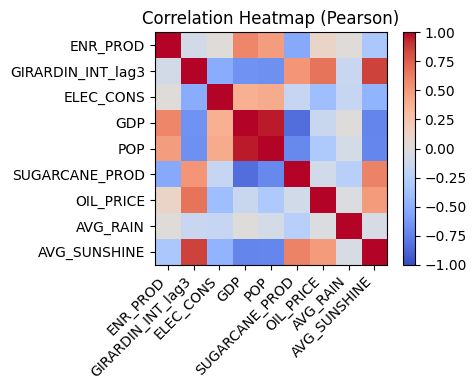

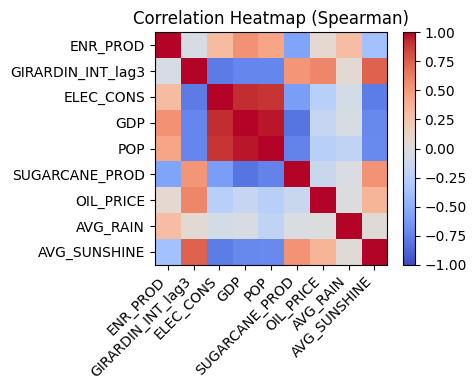

In [314]:
d_2["GIRARDIN_INT_lag3"] = d_2["GIRARDIN_INT"].shift(3)

d_2_clean = d_2.dropna().copy()

corr_cols_2 = [
    "ENR_PROD",
    "GIRARDIN_INT_lag3",   # Use lagged fiscal variable
    "ELEC_CONS",
    "GDP",
    "POP",
    "SUGARCANE_PROD",
    "OIL_PRICE",
    "AVG_RAIN",
    "AVG_SUNSHINE"
]

corr_pearson_2 = d_2_clean[corr_cols_2].corr(method="pearson")
corr_spearman_2 = d_2_clean[corr_cols_2].corr(method="spearman")


# Heatmap Pearson
plt.figure(figsize=(5, 4))
im = plt.imshow(corr_pearson_2, cmap="coolwarm", vmin=-1, vmax=1)
plt.colorbar(im)
plt.xticks(range(len(corr_pearson_2.columns)), corr_pearson_2.columns, rotation=45, ha='right')
plt.yticks(range(len(corr_pearson_2.columns)), corr_pearson_2.columns)
plt.title("Correlation Heatmap (Pearson)")
plt.tight_layout()
plt.show()

# Heatmap Spearman
plt.figure(figsize=(5, 4))
im = plt.imshow(corr_spearman_2, cmap="coolwarm", vmin=-1, vmax=1)
plt.colorbar(im)
plt.xticks(range(len(corr_spearman_2.columns)), corr_spearman_2.columns, rotation=45, ha='right')
plt.yticks(range(len(corr_spearman_2.columns)), corr_spearman_2.columns)
plt.title("Correlation Heatmap (Spearman)")
plt.tight_layout()
plt.show()

The same conclusion can be drawn from these heatmaps as in the initial analysis. We will need to perform the same ADF and VIF tests to determine which lag value should be retained in the regression model.

#### 7.1.4 ADF

As GDP and POP are highly corelated, we will keep GDP.

In [315]:
def adf_result_2(series, name):
    s = series.dropna()
    result = adfuller(s, autolag='AIC')
    stat, pvalue, lags, obs, crit = result[0], result[1], result[2], result[3], result[4]
    return {
        "Variable": name,
        "ADF Statistic": round(stat, 4),
        "p-value": round(pvalue, 4),
        "Stationary (5% level)": "YES" if stat < crit['5%'] else "NO"
    }

vars_to_test = ["ENR_PROD", "GIRARDIN_INT_lag3", "ELEC_CONS", "GDP","SUGARCANE_PROD", "OIL_PRICE", "AVG_RAIN", "AVG_SUNSHINE"]
vars_to_test = [v for v in vars_to_test if v in d_2.columns]

adf_table = pd.DataFrame([adf_result_2(d_2[v], v) for v in vars_to_test])
print("=== ADF Unit Root Test Results ===")
display(adf_table)

=== ADF Unit Root Test Results ===


,Variable,ADF Statistic,p-value,Stationary (5% level)
0,ENR_PROD,-4.4439,0.0002,YES
1,GIRARDIN_INT_lag3,-3.4172,0.0104,YES
2,ELEC_CONS,-2.3991,0.1420,NO
3,GDP,-0.1484,0.9444,NO
4,SUGARCANE_PROD,1.6101,0.9979,NO
5,OIL_PRICE,-2.5566,0.1023,NO
6,AVG_RAIN,-4.8495,0.0000,YES
7,AVG_SUNSHINE,-0.3179,0.9229,NO


Varibles have to be differentiate in this model again.

In [316]:
d_2["d_2_ENR"] = d_2["ENR_PROD"].diff()
d_2["d_2_GIRARDIN_lag3"] = d_2["GIRARDIN_INT_lag3"].diff()
d_2["d_2_ELEC_CONS"] = d_2["ELEC_CONS"].diff()
d_2["d_2_GDP"] = d_2["GDP"].diff()
d_2["d_2_SUGARCANE"] = d_2["SUGARCANE_PROD"].diff()
d_2["d_2_OIL_PRICE"] = d_2["OIL_PRICE"].diff()
d_2["d_2_SUNSHINE"] = d_2["AVG_SUNSHINE"].diff()

# Rain stays in levels (stationary)
# Removing the first row with NaN
d_2 = d_2.dropna().reset_index(drop=True)

d_2[["YEAR", "d_2_ENR", "d_2_GIRARDIN_lag3", "d_2_ELEC_CONS", "d_2_GDP", "d_2_OIL_PRICE", "d_2_SUGARCANE", "d_2_SUNSHINE", "AVG_RAIN"]].head()

,YEAR,d_2_ENR,d_2_GIRARDIN_lag3,d_2_ELEC_CONS,d_2_GDP,d_2_OIL_PRICE,d_2_SUGARCANE,d_2_SUNSHINE,AVG_RAIN
0,2010,60.8,90000000.0,79.0,200000000.0,16.52,-29267.0,19980.0,2307.671429
1,2011,-79.6,110000000.0,32.0,900000000.0,30.08,10047.0,1140.0,1739.841667
2,2012,140.8,112000000.0,41.0,300000000.0,1.99,-51458.0,-4626.0,1964.366667
3,2013,89.2,-32000000.0,-2285.0,200000000.0,-3.58,-118121.0,8615.0,2663.050000
4,2014,-120.7,5000000.0,2349.0,500000000.0,-9.58,45991.0,8790.0,2128.546154


#### 7.1.5 VIF

In [317]:
X_vars_2 = ["d_2_GIRARDIN_lag3", "d_2_ELEC_CONS", "d_2_GDP", "d_2_OIL_PRICE", 
          "d_2_SUGARCANE", "d_2_SUNSHINE", "AVG_RAIN"]


X_vars_2 = [v for v in X_vars_2 if v in d_2.columns]
X_2 = d_2[X_vars_2].dropna().copy()
X_with_const_2 = sm.add_constant(X_2)

vif_data_2 = pd.DataFrame()
vif_data_2["Variable"] = X_with_const_2.columns
vif_data_2["VIF"] = [variance_inflation_factor(X_with_const_2.values, i) 
                   for i in range(X_with_const_2.shape[1])]

print("=== VIF Results ===")
display(vif_data_2)

=== VIF Results ===


,Variable,VIF
0,const,102.623978
1,d_2_GIRARDIN_lag3,3.497614
2,d_2_ELEC_CONS,1.268479
3,d_2_GDP,5.108833
4,d_2_OIL_PRICE,5.837225
5,d_2_SUGARCANE,4.513379
6,d_2_SUNSHINE,3.097700
7,AVG_RAIN,6.707842


Variance Inflation Factor (VIF) diagnostics confirm that sugarcane production does not provide unique explanatory power in the production model. Its VIF (≈ 4.5) reflects strong co-movement with macroeconomic activity and climatic conditions, which are already captured by GDP and rainfall. Including it would therefore introduce redundancy and noise, reducing the statistical power of the estimation. For this reason, SUGARCANE_PROD is excluded from the final specification.

Concerning GDP and OIL_PRICE, those tends to go in the same direction of macraeconomics trends, we should therefore only keep one variable to reduce the noise.

In [318]:
X_vars_2 = ["d_2_GIRARDIN_lag3", "d_2_ELEC_CONS", "d_2_GDP", 
        "d_2_SUNSHINE", "AVG_RAIN"]


X_vars_2 = [v for v in X_vars_2 if v in d_2.columns]
X_2 = d_2[X_vars_2].dropna().copy()
X_with_const_2 = sm.add_constant(X_2)

vif_data_2 = pd.DataFrame()
vif_data_2["Variable"] = X_with_const_2.columns
vif_data_2["VIF"] = [variance_inflation_factor(X_with_const_2.values, i) 
                   for i in range(X_with_const_2.shape[1])]

print("=== VIF Results ===")
display(vif_data_2)

=== VIF Results ===


,Variable,VIF
0,const,36.085074
1,d_2_GIRARDIN_lag3,1.856243
2,d_2_ELEC_CONS,1.116357
3,d_2_GDP,1.262774
4,d_2_SUNSHINE,1.500160
5,AVG_RAIN,1.971488


Variance Inflation Factor (VIF) results indicate that multicollinearity is no longer a concern in the production model.  
All explanatory variables present VIF values well below the conventional threshold of 5, confirming that each variable provides unique information to the regression.  
This specification therefore ensures stable and interpretable coefficients for the estimation of the delayed Girardin effect on renewable energy production.

### 7.2 OLS Regression

Now that we have defined the relevant variables for our OLS regression, we present the following specification:

This model estimates the **effect of Girardin-financed investment on annual changes in renewable energy production**, controlling for economic activity, energy consumption, prices, and climatic conditions:

$$
\Delta ENR\_PROD_t = \alpha + \beta_1 \Delta GIRARDIN_{t-3} + \beta_2 \Delta ELEC\_CONS_t + \beta_3 \Delta GDP_t + \beta_4 \Delta SUNSHINE_t + \beta_5 RAIN_t + \varepsilon_t
$$

**Where:**

- $(\Delta ENR\_PROD_t) = \text{Annual change in renewable energy production}$ 
- $(\Delta GIRARDIN_{t-3}) = \text{Annual change in Girardin-financed investment}$  
- $(\Delta ELEC\_CONS_t) = \text{Annual change in electricity consumption}$
- $(\Delta GDP_t) = \text{Annual change in GDP}$
- $(\Delta SUNSHINE_t) = \text{Annual change in average sunshine duration}$ 
- $(RAIN_t) = \text{Annual average precipitation}$
- $(\varepsilon_t) = \text{Error term}$

In [319]:
y_2 = d_2["d_2_ENR"]  # dependant variable
X_2 = d_2[["d_2_GIRARDIN_lag3", "d_2_ELEC_CONS", "d_2_GDP", "d_2_SUNSHINE", "AVG_RAIN"]]
X_2 = sm.add_constant(X_2)

model_2 = sm.OLS(y_2, X_2).fit(cov_type='HC3')  # HC3 = robust to heteroskedasticity
print(model_2.summary())

                            OLS Regression Results                            
Dep. Variable:                d_2_ENR   R-squared:                       0.446
Model:                            OLS   Adj. R-squared:                  0.099
Method:                 Least Squares   F-statistic:                    0.7620
Date:                Tue, 11 Nov 2025   Prob (F-statistic):              0.602
Time:                        14:36:49   Log-Likelihood:                -88.713
No. Observations:                  14   AIC:                             189.4
Df Residuals:                       8   BIC:                             193.3
Df Model:                           5                                         
Covariance Type:                  HC3                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              -462.7543    575.44

/Users/jeremymartin/.venv/lib/python3.13/site-packages/scipy/stats/_axis_nan_policy.py:430: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=14 observations were given.
  return hypotest_fun_in(*args, **kwds)


The coefficient associated with the lagged Girardin incentive (Δ Girardin_int lag 3) remains positive, indicating that increases in fiscal investment incentives tend to be followed by increases in renewable electricity production. However, the effect is not statistically significant at conventional levels (p = 0.25), which suggests that the transmission from financial stimulus to effective output takes place through several intermediate steps (installation, commissioning, operational ramp-up), and is therefore weaker and more diffuse than the effect on installed capacity.

Similarly, none of the other explanatory variables display significant effects in first differences, although their signs are consistent with theoretical expectations: electricity consumption (proxy for demand) and GDP (economic activity) show small positive associations, while climatic variability (sunshine and rainfall) contributes noise to short-term production dynamics.

Overall, the model explains a moderate share of year-on-year variation in renewable energy output (R² = 0.45), but most of this variation remains driven by operational and meteorological shocks rather than by investment incentives directly. This result is consistent with the idea that the Girardin mechanism primarily affects capacity expansion, while its effect on effective renewable generation materializes only gradually and depends on weather-dependent production conditions.

#### 7.3 Robustness Checks

#### 7.3.1 Breusch–Godfrey test for residual autocorrelation

In [320]:
bg_test_2 = acorr_breusch_godfrey(model_2, nlags=1)  
print("Breusch-Godfrey:")
print(f"LM stat = {bg_test_2[0]:.3f}, p-value = {bg_test_2[1]:.3f}")

Breusch-Godfrey:
LM stat = 1.126, p-value = 0.289


The Breusch–Godfrey test shows no evidence of residual autocorrelation (p = 0.289). This confirms that the error structure is well-behaved and the model does not suffer from dynamic misspecification.

#### 7.3.2 Model specification (Ramsey RESET test)

In [321]:
reset_2 = linear_reset(model_2, power=2, use_f=True)
print(reset_2)

<F test: F=0.8748727265616293, p=0.3807458859557806, df_denom=7, df_num=1>


The Ramsey RESET test does not reject the null hypothesis of correct model specification (p = 0.38 > 0.05). This suggests that the linear functional form is adequate and that the model does not exhibit evidence of omitted nonlinear relationships.

#### 7.3.3 Heteroskedasticity (formal test) — Breusch–Pagan test

In [322]:
bp_test_2 = het_breuschpagan(model_2.resid, model_2.model.exog)
print(f"BP stat = {bp_test_2[0]:.3f}, p-value = {bp_test_2[1]:.3f}")

BP stat = 3.109, p-value = 0.683


The Breusch–Pagan test indicates no evidence of heteroskedasticity in the residuals (p = 0.68 > 0.05). This supports the assumption of homoskedastic errors, and the use of robust HC3 standard errors remains appropriate but not strictly necessary.

Overall, the robustness checks validate the reliability of the regression specification used in the analysis. The absence of autocorrelation (Breusch–Godfrey), heteroskedasticity (Breusch–Pagan), and misspecification (RESET) indicates that the model is statistically well-behaved. Therefore, the estimated coefficients can be interpreted with confidence, within the limits imposed by the relatively small sample size.